In [1]:
import pandas as pd  # For data manipulation
import numpy as np  # For data manipulation
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For data visualization
from sklearn.model_selection import train_test_split  # For splitting the data into train and test
from sklearn.linear_model import LinearRegression  # For training the algorithm
from sklearn.tree import DecisionTreeRegressor  # For training the algorithm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  # For training the algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR  # For training the algorithm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor  # For training the algorithm
from tensorflow import keras  # For training the algorithm
from tensorflow.keras import layers  # For training the algorithm
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For model evaluation
import tensorflow as tf  # For training the algorithm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lifelines import CoxPHFitter  # For Cox Proportional Hazards Model
from reliability.Fitters import Fit_Weibull_2P, Fit_Weibull_ZI
from sklearn import tree
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

C:\Users\joseg\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_2022 = pd.read_excel('Failure log 2022.xlsx', sheet_name='paradas')
df_2023 = pd.read_excel('Failure log 2023.xlsx', sheet_name='paradas')
df_2024 = pd.read_excel('Failure log 2024.xlsx', sheet_name='paradas')

In [3]:
df_log = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)
df_log.head()
print(df_log.columns)

Index(['parada', 'maquina', 'empresa', 'linea', 'maquina2', 'nombre', 'causa_parada_descripcion', 'parada_fecha', 'parada_hora', 'resolucion_fecha', 'resolucion_hora', 'parada_duracion (SEC)', 'min',
       'causa', 'detalle', 'N° semana', 'Mes', 'Turno', 'TECNICO', 'Con repuesto ( si / no)', 'OT', 'costo MOD', 'costo de repuesto'],
      dtype='object')


In [4]:
columns_to_drop = ['parada', 'empresa', 'maquina2', 'nombre', 'OT', 'N° semana', 'Mes', 'Turno', 'TECNICO',
       'Con repuesto ( si / no)', 'OT', 'costo MOD', 'costo de repuesto']
df = df_log.drop(columns=columns_to_drop)

In [5]:
df.head()

,maquina,linea,causa_parada_descripcion,parada_fecha,...,parada_duracion (SEC),min,causa,detalle
0,Llenadora,L43,Mantenimiento Mecanico,2022-01-03,...,2923,48.7167,llenadora sobre llenado de los picos se regul...,ajuste
1,Llenadora,L35,Mantenimiento Mecanico,2022-01-03,...,456,7.6,micro parada,micro parada
2,Llenadora,L39,Mantenimiento Electrico,2022-01-03,...,4223,70.3833,reemplazo de panel lenze quemado,rotura
3,Llenadora,L35,Mantenimiento Electrico,2022-01-03,...,2123,35.3833,se regula sensor contador de mecanismos,ajuste
4,Llenadora,L43,Mantenimiento Mecanico,2022-01-03,...,5275,87.9167,llenadora sobre llenado de los picos se regul...,ajuste


In [6]:
translation_dict = {
    'maquina': 'machine',
    'linea': 'line',
    'causa_parada_descripcion': 'stop_cause_description',
    'parada_fecha': 'stop_date',
    'parada_hora': 'stop_time',
    'resolucion_fecha': 'resolution_date',
    'resolucion_hora': 'resolution_time',
    'parada_duracion (SEC)': 'stop_duration_sec',
    'min': 'stop_duration_min',
    'causa': 'cause',
    'detalle': 'detail',
}

# Renombrar las columnas
df.rename(columns=translation_dict, inplace=True)

# Verificar el resultado
df.head()

,machine,line,stop_cause_description,stop_date,...,stop_duration_sec,stop_duration_min,cause,detail
0,Llenadora,L43,Mantenimiento Mecanico,2022-01-03,...,2923,48.7167,llenadora sobre llenado de los picos se regul...,ajuste
1,Llenadora,L35,Mantenimiento Mecanico,2022-01-03,...,456,7.6,micro parada,micro parada
2,Llenadora,L39,Mantenimiento Electrico,2022-01-03,...,4223,70.3833,reemplazo de panel lenze quemado,rotura
3,Llenadora,L35,Mantenimiento Electrico,2022-01-03,...,2123,35.3833,se regula sensor contador de mecanismos,ajuste
4,Llenadora,L43,Mantenimiento Mecanico,2022-01-03,...,5275,87.9167,llenadora sobre llenado de los picos se regul...,ajuste


In [7]:
df.shape

(14648, 11)

In [8]:
#df['machine'].unique()
#df['line'].unique()
#df['stop_cause_description'].unique()
#df['cause'].unique()
df['detail'].unique()

array(['ajuste', 'micro parada', 'rotura', 'sin informacion', 'no aplica',
       'microparada', 'ajuste leve', 'quiebra falla', 'fusible', nan],
      dtype=object)

In [9]:
machine_translation_dict = {
    'Llenadora' : 'Filler',
    'Etiquetadora' : 'Labeler',
    'E33 Valvula' : 'Valve',
    'Laser' : 'Laser',
    'Brazo transporte' : 'Transport Arm',
    'Etiquetadora de fondo' : 'Bottom Labeler',
    'Estuchadora' : 'Cartoner',
    'LogiPack' : 'LogiPack',
    'Molino' : 'Mill',
    'Celofanadora' : 'Cellophaner',
    'Torqueadora' : 'Torqueing Machine',
    'Abastecedor pinceles' : 'Brush Feeder',
    'Termosellado' : 'Heat Sealer',
    'Bomba de vacío' : 'Vacuum Pump',
    'Axon' : 'Axon',
    'Transporte' : 'Conveyor',
    'Crimpadora' : 'Crimper',
    'Inkjet' : 'Inkjet',
    'Llenadora L38' : 'Filler',
    'Abastecedor de bombas' : 'Pump Feeder',
    'Crimpadora L11' : 'Crimper',
    'Etiquetadora L33' : 'Labeler',
    'Camara' : 'Camera',
    'Bajador tetina' : 'Nipple Lowerer',
    'Abastecedor de tapas' : 'Cap Feeder',
    'E20 Valvula' : 'Valve',
    'Martillo' : 'Hammer',
    'Transfer' : 'Transfer',
    'Llenadora L37' : 'Filler',
    'Tolva' : 'Hopper',
    'Temperatura Equipo' : 'Equipment Temperature',
    'Celofanadora L10' : 'Cellophaner',
    'Abastecedor de envases' : 'Container Feeder',
    'Pick and play' : 'Pick and Place',
    'Coloca Tapas' : 'Cap Placer',
    'Paleta' : 'Pallet',
    'Roscadora' : 'Screw Capper',
    'Coloca Bombas' : 'Pump Placer',
    'Falla en la tapa' : 'Cap Failure',
    'Embalador' : 'Packer',
    'Coloca Bolillas' : 'Ball Placer',
    'Abastecedor de bolillas' : 'Ball Feeder',
    'Girador de pucks' : 'Puck Rotator',
    'Balanza' : 'Scale',
    'Enhebrado/Coloca Bombas' : 'Threading/Pump Placer',
    'Valvula' : 'Valve',
    'Bomba Neumatica' : 'Pneumatic Pump',
    'Picos' : 'Nozzles',
    'Abastecedor tubos' : 'Tube Feeder',
    'Bomba Moyno' : 'Moyno Pump',
    'E38 Valvula' : 'Valve',
    'Sobretapa' : 'Overcap',
    'E20 Agitador' : 'Agitator',
    'Tanque Stock' : 'Stock Tank',
    'E24 TK Purgado' : 'Purging Tank',
    'E24 Agitador' : 'Agitator',
    'Agitador' : 'Agitator',
    'E24 Valvula' : 'Valve',
    'Abastecedor tetina' : 'Nipple Feeder',
    'Mordazas' : 'Jaws',
    'Abastecedor de mecanismos' : 'Mechanism Feeder',
    'Picking Forzado' : 'Forced Picking',
    'Bajador de tapas' : 'Cap Lowerer',
    'No Larga' : 'Doesn’t Start',
    'Cozolli' : 'Cozolli',
    'Soldador' : 'Welder',
    'Llenadora L16' : 'Filler',
    'Estrella' : 'Star'
}

line_translation_dict = {
    'L43': 'L43',
    'L35': 'L35',
    'L39': 'L39',
    'L45': 'L45',
    'Eq 33 - 38': 'L33',
    'L10': 'L10',
    'L37': 'L37',
    'L11': 'L11',
    'Equipo 01': 'L01',
    'Equipo 15': 'L15',
    'L32': 'L32',
    'L48': 'L48',
    'L38': 'L38',
    'L33': 'L33',
    'L41': 'L41',
    'L27': 'L27',
    'L42': 'L42',
    'Eq 24 - 20': 'L20',
    'Equipo 12': 'L12',
    'Equipo 18': 'L18',
    'L04': 'L04',
    'L12': 'L12',
    'L36': 'L36',
    'L07': 'L07',
    'L19': 'L19',
    'L29': 'L29',
    'Equipo 37': 'L37',
    'Equipo 34': 'L34',
    'L20': 'L20',
    'Equipo 19': 'L19',
    'L47': 'L47',
    'L16': 'L16'
}

stop_cause_description_translation_dict = {
    'Mantenimiento Mecanico': 'Mechanical Maintenance',
    'Mantenimiento Electrico': 'Electrical Maintenance',
    'Mantenimiento Preventivo': 'Preventive Maintenance',
    'Quebra/Falha Mecânica': 'Mechanical Maintenance',
    'Quebra/Falha elétrica e Eletronica': 'Electrical Maintenance'
}

detail_translation_dict = {
    'ajuste': 'adjustment',
    'micro parada': 'micro stop',
    'rotura': 'breakdown',
    'sin informacion': 'no information',
    'no aplica': 'not applicable',
    'microparada': 'micro stop',
    'ajuste leve': 'minor adjustment',
    'quiebra falla': 'breakdown',
    'fusible': 'fuse',
    'nan': 'no information'
}

df.rename(columns=translation_dict, inplace=True)

# Aplicar la traducción a las columnas 'machine', 'stop_cause_description' y 'detail'
df['machine'] = df['machine'].replace(machine_translation_dict)
df['line'] = df['line'].replace(line_translation_dict)
df['stop_cause_description'] = df['stop_cause_description'].replace(stop_cause_description_translation_dict)
df['detail'] = df['detail'].replace(detail_translation_dict)
df.head()

,machine,line,stop_cause_description,stop_date,...,stop_duration_sec,stop_duration_min,cause,detail
0,Filler,L43,Mechanical Maintenance,2022-01-03,...,2923,48.7167,llenadora sobre llenado de los picos se regul...,adjustment
1,Filler,L35,Mechanical Maintenance,2022-01-03,...,456,7.6,micro parada,micro stop
2,Filler,L39,Electrical Maintenance,2022-01-03,...,4223,70.3833,reemplazo de panel lenze quemado,breakdown
3,Filler,L35,Electrical Maintenance,2022-01-03,...,2123,35.3833,se regula sensor contador de mecanismos,adjustment
4,Filler,L43,Mechanical Maintenance,2022-01-03,...,5275,87.9167,llenadora sobre llenado de los picos se regul...,adjustment


In [10]:
df['stop_date'] = pd.to_datetime(df['stop_date'], format='%d-%m-%Y', errors='coerce')  # Convert 'Stop_date' column to datetime
df['resolution_date'] = pd.to_datetime(df['resolution_date'], format='%d-%m-%Y', errors='coerce')  # Convert 'Resolution_date' column to datetime
print("\nData Types:")  # Print the data types of each column
print(df.dtypes)  # Print the data types of each column


Data Types:
machine                           object
line                              object
stop_cause_description            object
stop_date                 datetime64[ns]
stop_time                         object
resolution_date           datetime64[ns]
resolution_time                   object
stop_duration_sec                float64
stop_duration_min                float64
cause                             object
detail                            object
dtype: object


In [11]:
# Checking for Missing Values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


Missing Values in Each Column:
machine                    0
line                       0
stop_cause_description     0
stop_date                  3
stop_time                  3
resolution_date           20
resolution_time           20
stop_duration_sec          0
stop_duration_min          0
cause                      2
detail                    31
dtype: int64


In [12]:
df.shape

(14648, 11)

In [13]:
# Dropping Rows with Missing Values
# Specify the columns with missing values
columns_with_missing_values = ['resolution_date', 'resolution_time', 'detail']  # Specify the columns with missing values

df_cleaned = df.dropna(subset=columns_with_missing_values)

print("\nMissing Values After Dropping:")
print(df_cleaned.isnull().sum())  # Print the number of missing values in each column


Missing Values After Dropping:
machine                   0
line                      0
stop_cause_description    0
stop_date                 0
stop_time                 0
resolution_date           0
resolution_time           0
stop_duration_sec         0
stop_duration_min         0
cause                     0
detail                    0
dtype: int64


In [14]:
df_cleaned.shape

(14597, 11)

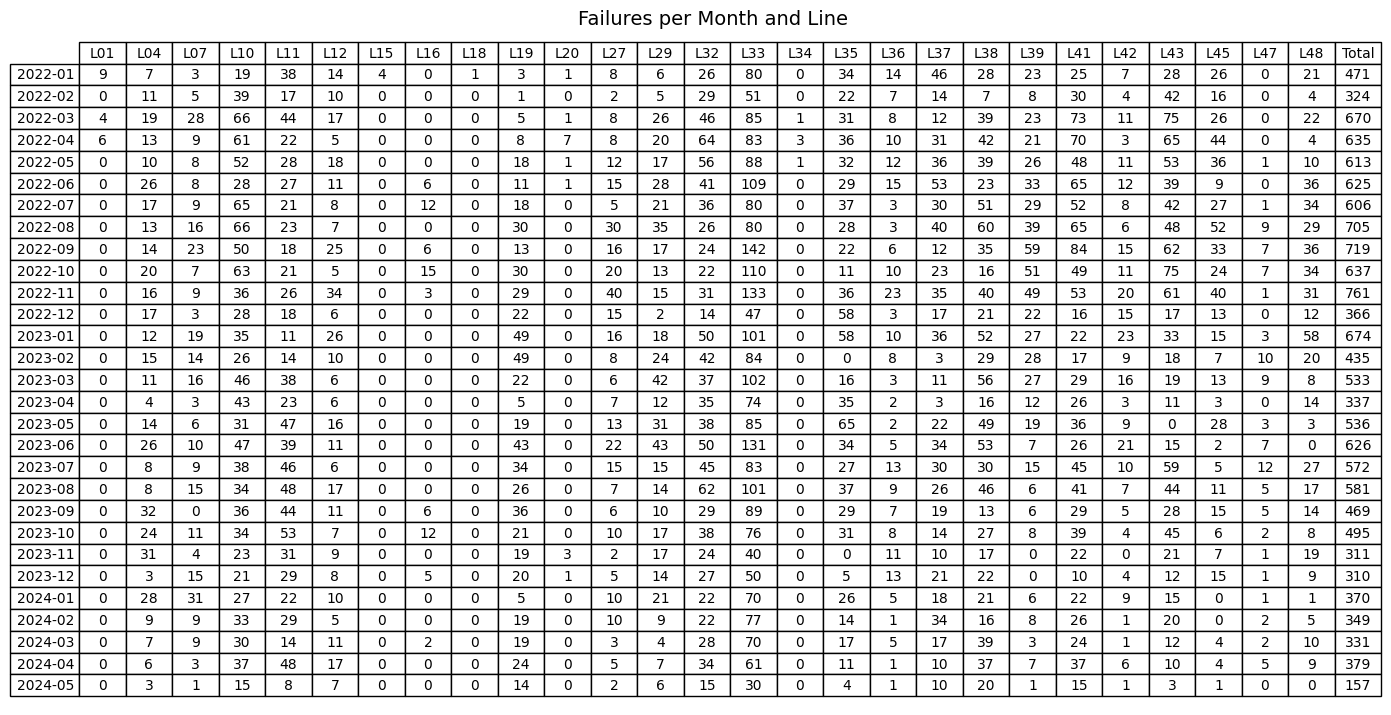

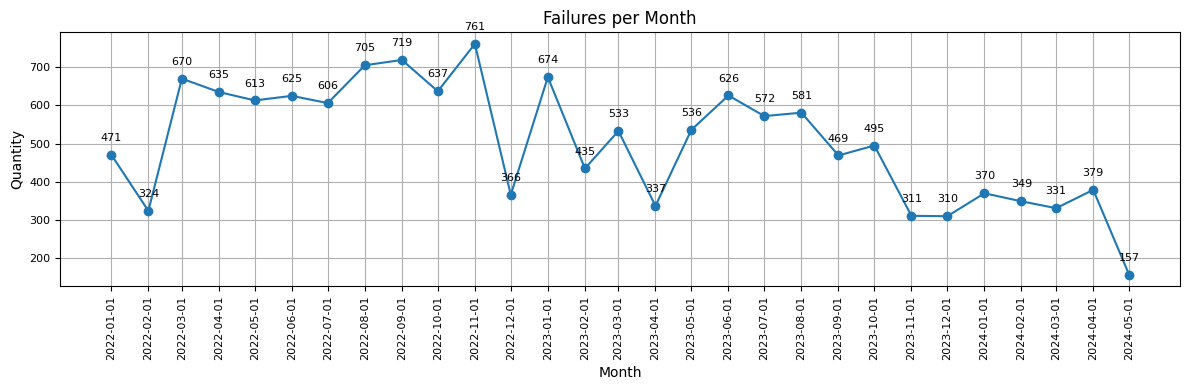

In [15]:
df_cleaned['stop_date'] = pd.to_datetime(df_cleaned['stop_date'])

# Crear una nueva columna para el mes
df_cleaned['month'] = df_cleaned['stop_date'].dt.to_period('M')

# Agrupar por mes y línea y contar las fallas
monthly_line_failures = df_cleaned.groupby(['month', 'line']).size().unstack(fill_value=0)

# Agregar una columna con el total de fallas por mes
monthly_line_failures['Total'] = monthly_line_failures.sum(axis=1)

# Convertir la columna 'month' de Period a datetime para graficar
monthly_line_failures.index = monthly_line_failures.index.to_timestamp()

# Graficar la tabla de fallas por mes y línea
fig, ax = plt.subplots(figsize=(14, 8))

# Crear la tabla
table = ax.table(cellText=monthly_line_failures.values, 
                 rowLabels=monthly_line_failures.index.strftime('%Y-%m'), 
                 colLabels=monthly_line_failures.columns, 
                 cellLoc='center', 
                 loc='center')

# Ajustar tamaño de las celdas
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Ajustar tamaño de las celdas

# Ocultar el gráfico
ax.axis('tight')
ax.axis('off')

# Añadir título con ajuste manual de la posición
plt.suptitle('Failures per Month and Line', fontsize=14)
plt.subplots_adjust(top=0.95)  # Ajustar para reducir el espacio entre el título y la tabla

plt.show()

monthly_failures = df_cleaned.groupby('month').size().reset_index(name='failures_count')

# Convertir la columna 'month' de Period a datetime para graficar
monthly_failures['month'] = monthly_failures['month'].dt.to_timestamp()

plt.figure(figsize=(12, 4))
plt.plot(monthly_failures['month'], monthly_failures['failures_count'], marker='o')

# Añadir etiquetas con los valores en cada punto
for i, row in monthly_failures.iterrows():
    plt.annotate(row['failures_count'], (row['month'], row['failures_count']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Asegurarse de que todos los valores del eje X se muestren
plt.xticks(monthly_failures['month'], rotation=90, fontsize=8)

plt.title('Failures per Month', fontsize=12)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Quantity', fontsize=10)
plt.grid(True)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

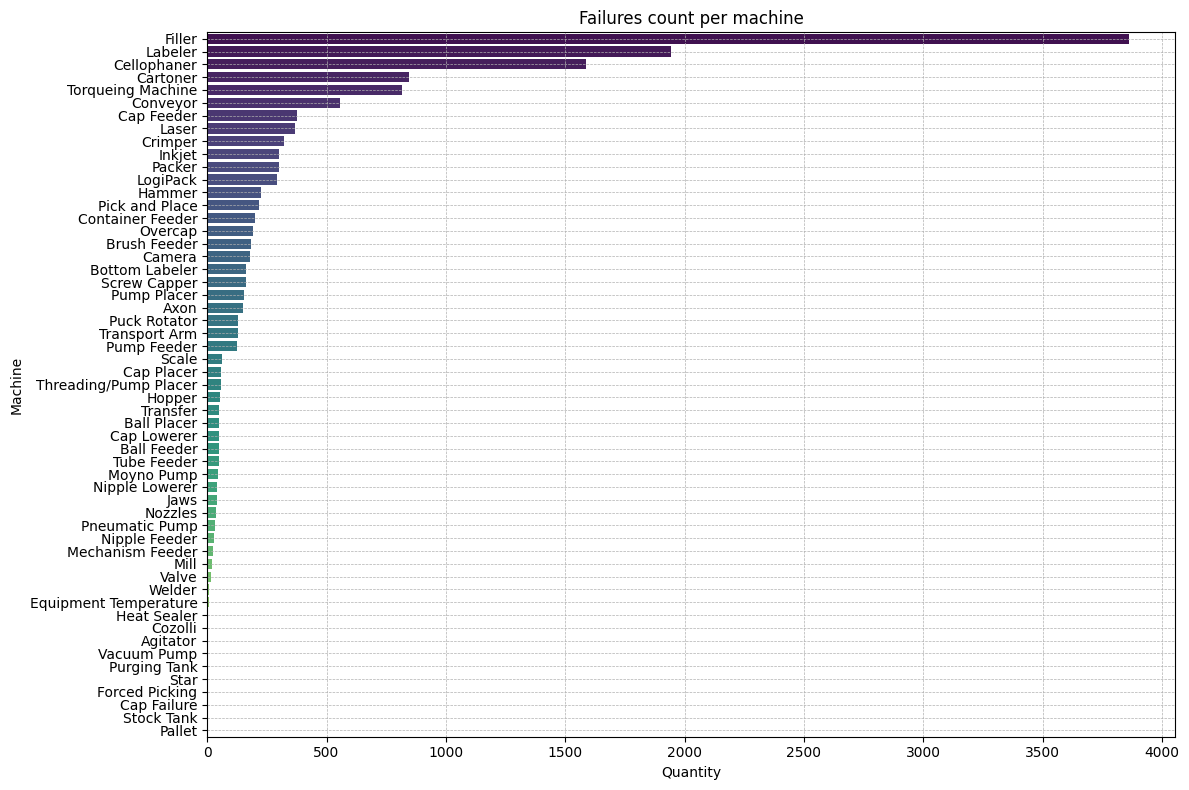

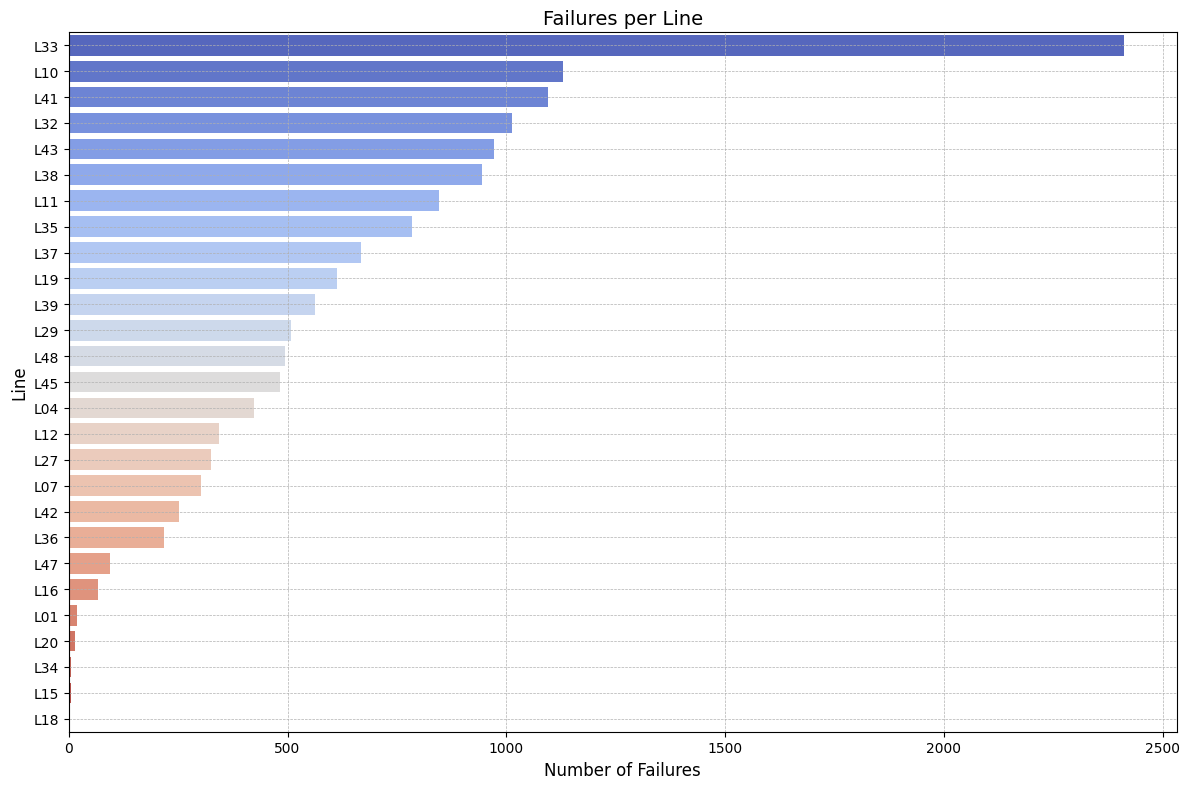

In [16]:
machine_failures = df_cleaned.groupby('machine').size().reset_index(name='failures_count')

# Ordenar por número de fallas
machine_failures = machine_failures.sort_values(by='failures_count', ascending=False)

# Graficar el número de fallas por máquina con barras horizontales
plt.figure(figsize=(12, 8))
sns.barplot(data=machine_failures, x='failures_count', y='machine', palette='viridis')

# Personalización del gráfico
plt.title('Failures count per machine')
plt.xlabel('Quantity')
plt.ylabel('Machine')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

line_failures = df_cleaned.groupby('line').size().reset_index(name='failures_count')

# Ordenar por número de fallas
line_failures = line_failures.sort_values(by='failures_count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=line_failures, x='failures_count', y='line', palette='coolwarm')

# Personalización del gráfico
plt.title('Failures count per line')
plt.xlabel('Quantity')
plt.ylabel('Line')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.title('Failures per Line', fontsize=14)
plt.xlabel('Number of Failures', fontsize=12)
plt.ylabel('Line', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

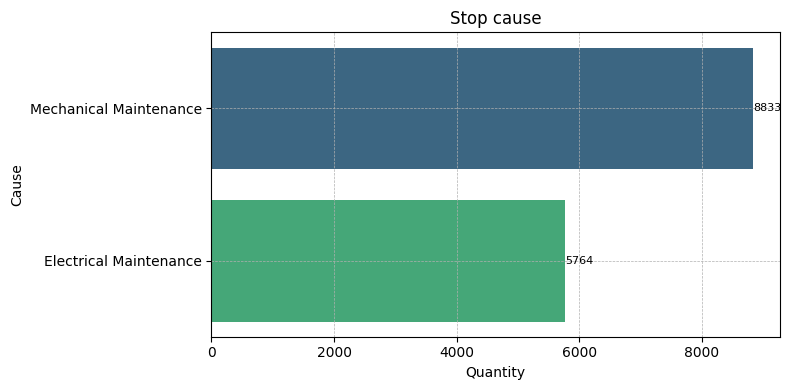

In [17]:
stop_cause = df_cleaned.groupby('stop_cause_description').size().reset_index(name='Quantity')

# Ordenar los datos para mejor visualización
stop_cause = stop_cause.sort_values(by='Quantity', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(8, 4))
bar_plot = sns.barplot(data=stop_cause, x='Quantity', y='stop_cause_description', palette='viridis')

# Personalización del gráfico
plt.title('Stop cause')
plt.xlabel('Quantity')
plt.ylabel('Cause')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Añadir los valores sobre las barras
for bar in bar_plot.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', 
             va='center', ha='left', color='black', fontsize=8)

plt.tight_layout()

# Mostrar el gráfico
plt.show()

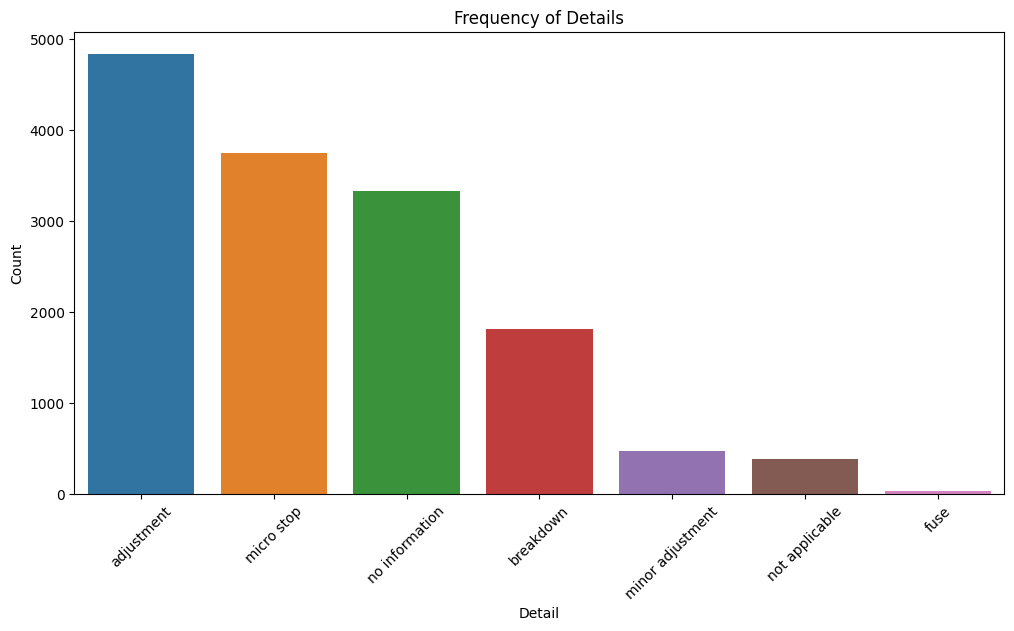

In [18]:
plt.figure(figsize=(12, 6))  # Set the figure size
sns.countplot(data=df_cleaned, x='detail', order=df_cleaned['detail'].value_counts().index)  # Plot the countplot
plt.title('Frequency of Details')  # Set the title
plt.xticks(rotation=45)  # Rotate the x-axis labels
plt.xlabel('Detail')  # Set the x-axis label
plt.ylabel('Count')  # Set the y-axis label
plt.show()  # Show the plot

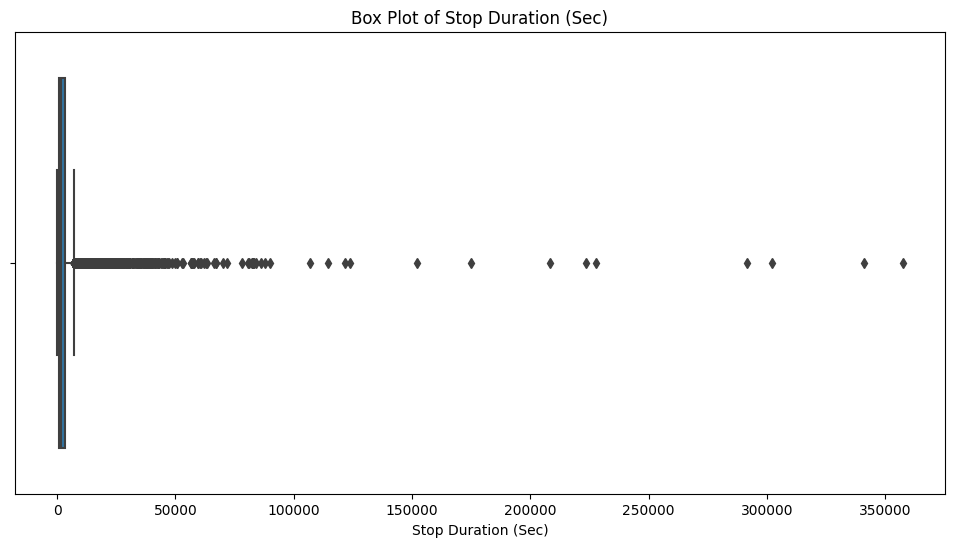

In [19]:
#Box Plot of 'Stop_duration (Sec)'
plt.figure(figsize=(12, 6))  # Set the figure size
sns.boxplot(x=df_cleaned['stop_duration_sec'])  # Plot the boxplot
plt.title('Box Plot of Stop Duration (Sec)')  # Set the title
plt.xlabel('Stop Duration (Sec)')  # Set the x-axis label
plt.show()  # Show the plot

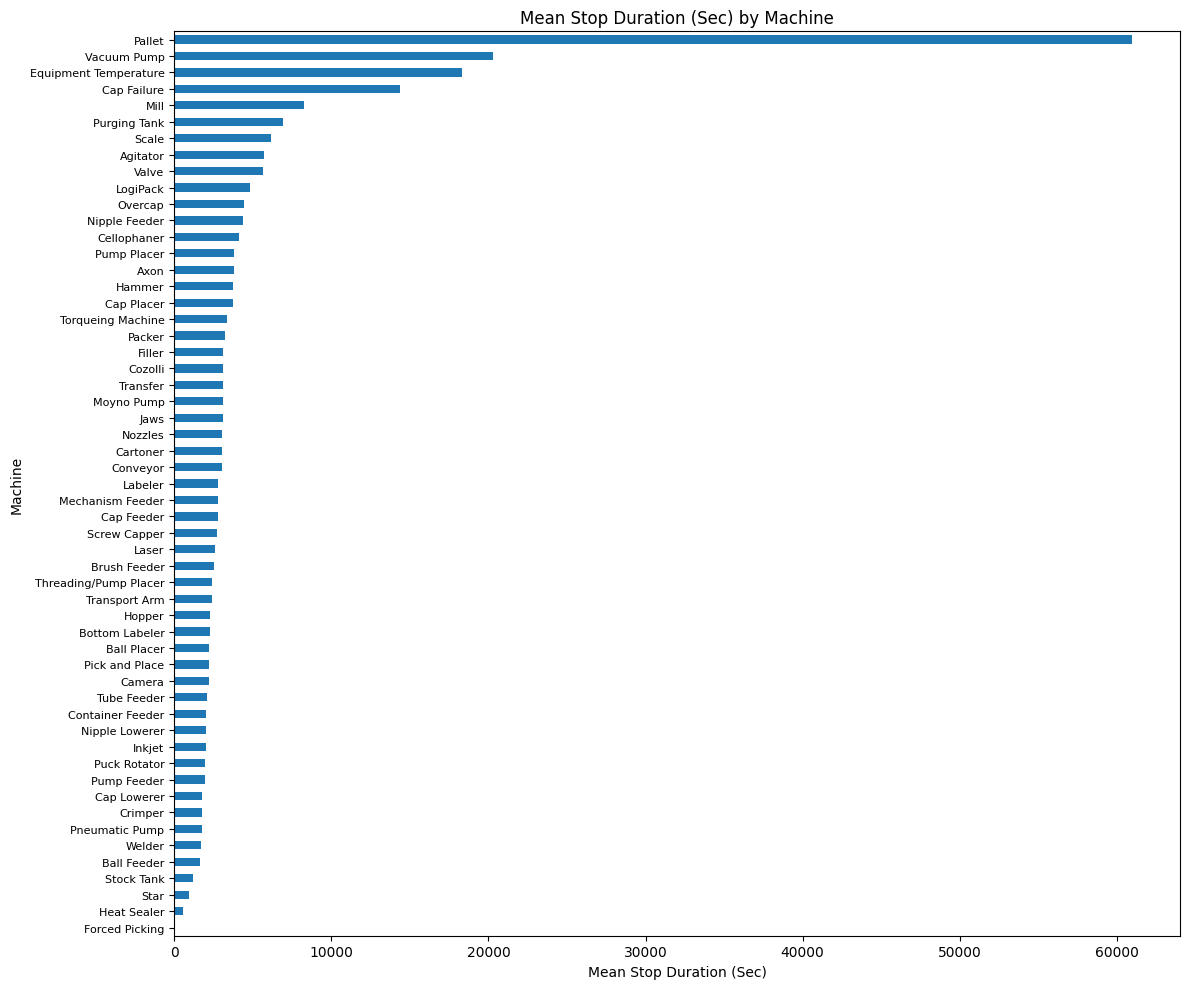

In [20]:
mean_duration_by_machine = df_cleaned.groupby('machine')['stop_duration_sec'].mean().sort_values()

plt.figure(figsize=(12, 10))
# Graficar el diagrama de barras horizontal
mean_duration_by_machine.plot(kind='barh')

# Ajustar el título y etiquetas de los ejes
plt.title('Mean Stop Duration (Sec) by Machine')
plt.xlabel('Mean Stop Duration (Sec)')
plt.ylabel('Machine')

# Ajustar las etiquetas del eje Y
plt.yticks(fontsize=8)  # Reducir el tamaño de la fuente de las etiquetas del eje Y
plt.tight_layout()  # Ajustar automáticamente el espaciado para que las etiquetas se muestren correctamente

# Mostrar el gráfico
plt.show()

In [21]:
mean_duration_by_machine = df_cleaned.groupby('machine')['stop_duration_min'].mean()
failure_count_by_machine = df_cleaned.groupby('machine')['stop_duration_min'].count()
summary_table = pd.DataFrame({
    'Mean Stop Duration (Min)': mean_duration_by_machine,
    'Failure Count': failure_count_by_machine
})
summary_table = summary_table.sort_values(by='Failure Count', ascending=False)
# Mostrar la tabla resultante
print(summary_table)

                       Mean Stop Duration (Min)  Failure Count
machine                                                       
Filler                                  52.2347           3861
Labeler                                 46.5882           1942
Cellophaner                              68.377           1588
Cartoner                                51.2188            847
Torqueing Machine                       55.8509            816
Conveyor                                51.1086            555
Cap Feeder                              46.0237            378
Laser                                   43.3836            370
Crimper                                 29.2421            321
Inkjet                                  33.3349            302
Packer                                  54.1364            299
LogiPack                                80.7197            293
Hammer                                  62.5673            226
Pick and Place                          34.2084        

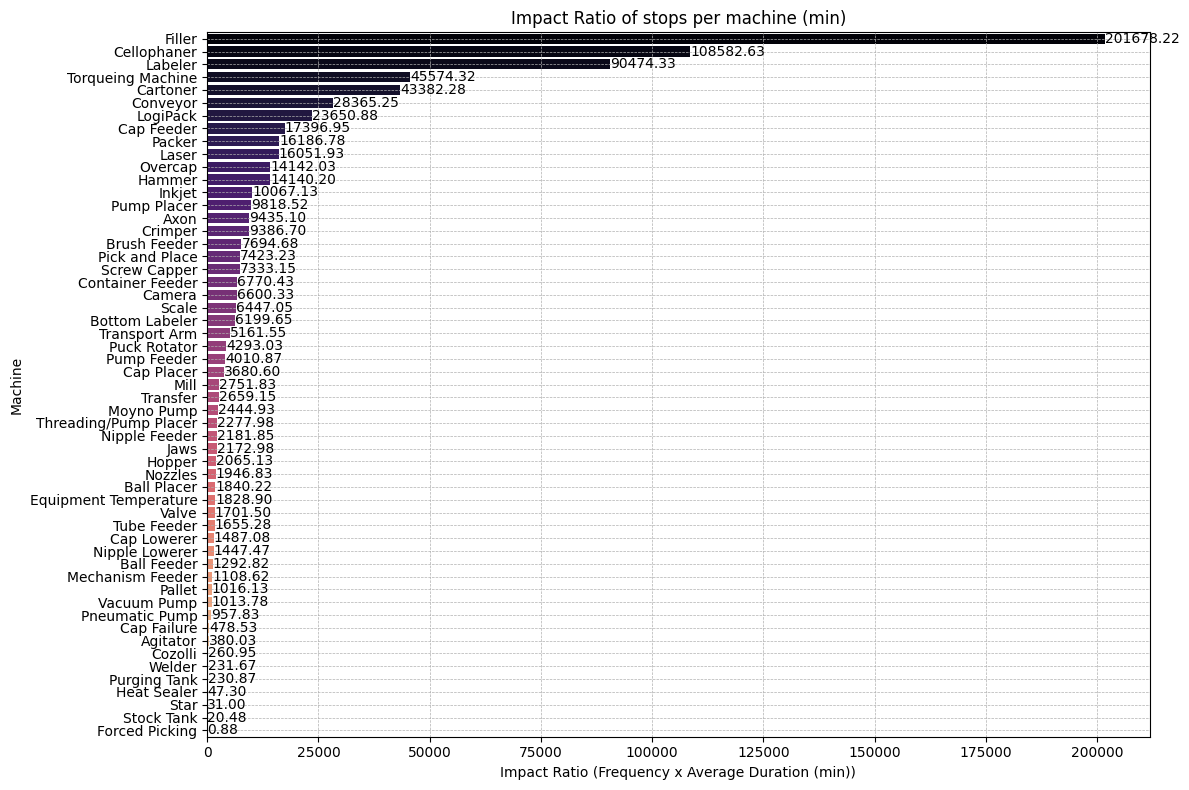

In [22]:
aggregated_data = df_cleaned.groupby('machine').agg(
    Quantity=('machine', 'size'),
    average_duration=('stop_duration_min', 'mean')
).reset_index()

# Calcular el índice de impacto como producto de frecuencia y duración promedio
aggregated_data['impact_factor'] = aggregated_data['Quantity'] * aggregated_data['average_duration']

# Ordenar los datos para mejor visualización
aggregated_data = aggregated_data.sort_values(by='impact_factor', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=aggregated_data, x='impact_factor', y='machine', palette='magma')

# Personalización del gráfico
plt.title('Impact Ratio of stops per machine (min)')
plt.xlabel('Impact Ratio (Frequency x Average Duration (min))')
plt.ylabel('Machine')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Añadir los valores sobre las barras
for bar in bar_plot.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='black', fontsize=10)

plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [23]:
# Agrupar por mes y contar las fallas
from scipy.stats import kendalltau

installation_date = pd.to_datetime('2022-01-01')

# Calcular la antigüedad de la máquina en días desde la fecha de instalación fija
df_cleaned['machine_age_days'] = (df_cleaned['stop_date'] - installation_date).dt.days

# Agrupar por la antigüedad de la máquina en días y contar el número de fallas
failures_by_age = df_cleaned.groupby('machine_age_days').size()

# Realizar la prueba de correlación de Kendall Tau
tau, p_value = kendalltau(failures_by_age.index, failures_by_age.values)

# Mostrar los resultados
print(f"Kendall tau: {tau:.3f}, P-value: {p_value:.3f}")

# Interpretación del resultado
if p_value < 0.05:
    print("The correlation is significant, so we can reject the null hypothesis.")
else:
    print("There is insufficient evidence to reject the null hypothesis.")

Kendall tau: -0.236, P-value: 0.000
The correlation is significant, so we can reject the null hypothesis.


#Null hypothesis 
#(H₀): There is a relationship between the age of the machine and the number of failures ("the older the machine gets, the more it fails").

#Alternative hypothesis 
#(H₁): There is no relationship between the age of the machine and the number of failures.


In [24]:
from scipy.stats import spearmanr

# Calcular la antigüedad de la máquina en días desde la fecha de instalación fija
df_cleaned['machine_age_days'] = (df_cleaned['stop_date'] - installation_date).dt.days

# Calcular la correlación de Spearman entre la antigüedad de la máquina en días y la duración de la parada
rho, p_value = spearmanr(df_cleaned['machine_age_days'], df_cleaned['stop_duration_sec'])
print(f"Spearman rho: {rho:.3f}, P-value: {p_value:.3f}")

# Interpretación
if p_value < 0.05:
    print("The correlation is significant, so we can reject the null hypothesis.")
else:
    print("There is insufficient evidence to reject the null hypothesis.")

Spearman rho: 0.038, P-value: 0.000
The correlation is significant, so we can reject the null hypothesis.


In [25]:
df_cleaned2 = df_cleaned.copy()

# Eliminar las columnas 'cause', 'month' y 'stop_duration_min'
df_cleaned2 = df_cleaned2.drop(columns=['cause', 'month', 'stop_duration_min'])

# Verificar que las columnas se han eliminado correctamente
print(df_cleaned2.columns)

Index(['machine', 'line', 'stop_cause_description', 'stop_date', 'stop_time', 'resolution_date', 'resolution_time', 'stop_duration_sec', 'detail', 'machine_age_days'], dtype='object')


# RANDOM FOREST

In [26]:
# Convertir fechas a datetime
df_cleaned2['stop_date'] = pd.to_datetime(df_cleaned2['stop_date'])
df_cleaned2['resolution_date'] = pd.to_datetime(df_cleaned2['resolution_date'])

# Codificación de variables categóricas
df_cleaned2['machine'] = LabelEncoder().fit_transform(df_cleaned2['machine'])
df_cleaned2['line'] = LabelEncoder().fit_transform(df_cleaned2['line'])
df_cleaned2['stop_cause_description'] = LabelEncoder().fit_transform(df_cleaned2['stop_cause_description'])
df_cleaned2['detail'] = LabelEncoder().fit_transform(df_cleaned2['detail'])

# Crear una columna objetivo 'failure'
df_cleaned2['failure'] = np.where(df_cleaned2['stop_duration_sec'] > 600, 1, 0)

# Crear característica de tiempo desde la última falla
df_cleaned2['previous_failure_time'] = df_cleaned2.groupby('machine')['stop_date'].shift(1)
df_cleaned2['time_since_last_failure'] = (df_cleaned2['stop_date'] - df_cleaned2['previous_failure_time']).dt.total_seconds()

# Rellenar con 0 para la primera falla de cada máquina
df_cleaned2['time_since_last_failure'] = df_cleaned2['time_since_last_failure'].fillna(0)

# Convertir la columna 'month' de Period a entero si existe
if 'month' in df_cleaned2.columns:
    df_cleaned2['month'] = df_cleaned2['month'].astype(str).str.extract(r'(\d+)').astype(int)

# Eliminar la columna 'failure' de las características (X)
X = df_cleaned2.drop(columns=['stop_date', 'resolution_date', 'stop_time', 'resolution_time', 'previous_failure_time', 'failure'])  
y = df_cleaned2['failure']  # Esta es la columna objetivo

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Entrenamiento del Modelo
model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluación del Modelo
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

# Importancia de las características
importances = model.feature_importances_
for i, v in enumerate(importances):
    print(f'Feature: {X.columns[i]}, Score: {v:.5f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       752
           1       1.00      1.00      1.00      2168

    accuracy                           1.00      2920
   macro avg       1.00      1.00      1.00      2920
weighted avg       1.00      1.00      1.00      2920

AUC-ROC: 1.0
Feature: machine, Score: 0.00134
Feature: line, Score: 0.00228
Feature: stop_cause_description, Score: 0.00280
Feature: stop_duration_sec, Score: 0.71667
Feature: detail, Score: 0.27016
Feature: machine_age_days, Score: 0.00553
Feature: time_since_last_failure, Score: 0.00122


In [27]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

print(f'AUC-ROC mean across folds: {cv_scores.mean()}')
print(f'AUC-ROC std across folds: {cv_scores.std()}')

AUC-ROC mean across folds: 0.9999945904410634
AUC-ROC std across folds: 1.0819117873062113e-05


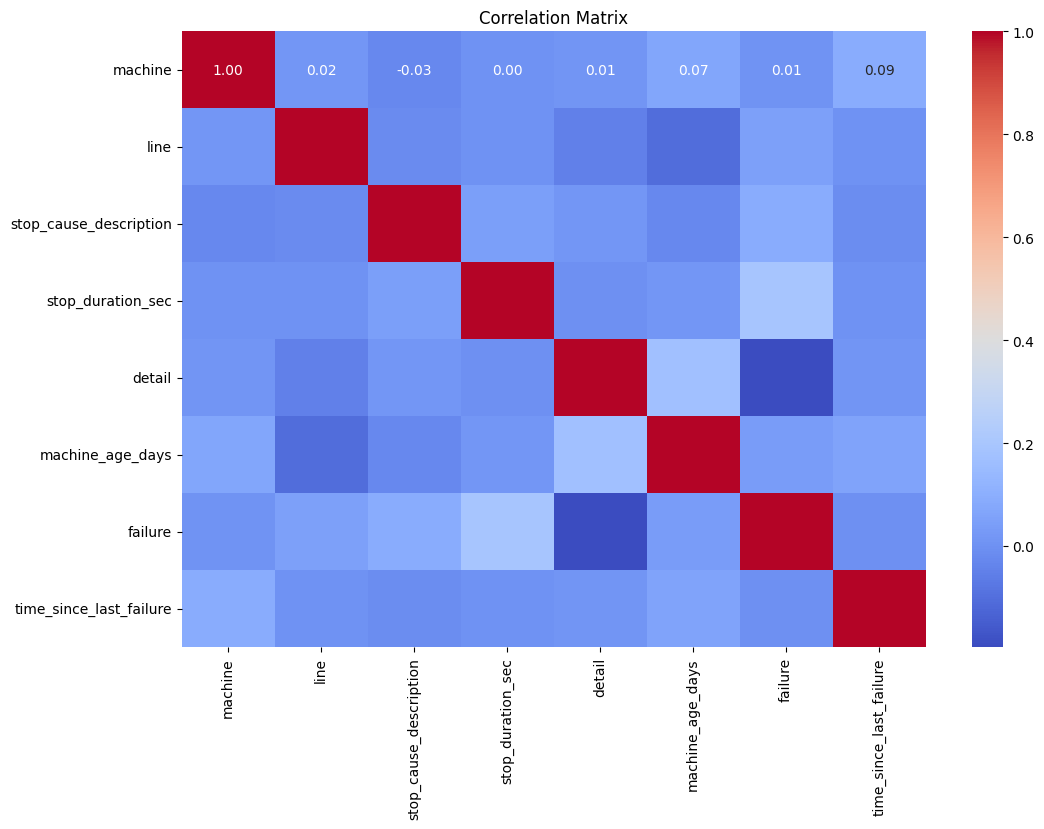

In [28]:
df_numeric = df_cleaned2.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [29]:
df_cleaned3 = df_cleaned.copy()

# Eliminar las columnas 'cause', 'month' y 'stop_duration_min'
df_cleaned3 = df_cleaned3.drop(columns=['cause', 'month', 'stop_duration_min'])

# Verificar que las columnas se han eliminado correctamente
print(df_cleaned3.columns)

Index(['machine', 'line', 'stop_cause_description', 'stop_date', 'stop_time', 'resolution_date', 'resolution_time', 'stop_duration_sec', 'detail', 'machine_age_days'], dtype='object')


In [30]:
df_l33 = df_cleaned3[df_cleaned3['line'] == 'L33']

# Crear un rango de fechas
date_range = pd.date_range(start='2022-01-01', end='2024-05-31', freq='D')

# Crear un DataFrame con todas las combinaciones posibles de máquina y fecha solo para L33
machines = df_l33['machine'].unique()
line = ['L33']  # Solo estamos interesados en la línea L33

full_combinations = pd.MultiIndex.from_product([machines, line, date_range], names=['machine', 'line', 'date'])
full_df = pd.DataFrame(index=full_combinations).reset_index()

# Unir el DataFrame original filtrado con el DataFrame completo de L33
df_complete_l33 = pd.merge(full_df, df_l33, how='left', left_on=['machine', 'line', 'date'], right_on=['machine', 'line', 'stop_date'])

# Crear la columna 'failure' y rellenarla con 1 si hay una falla (es decir, si 'stop_date' no es NaN) y 0 en caso contrario
df_complete_l33['failure'] = df_complete_l33['stop_date'].notna().astype(int)

# Rellenar otras columnas NaN si es necesario
df_complete_l33['stop_cause_description'] = df_complete_l33['stop_cause_description'].fillna('No Failure')
df_complete_l33['stop_duration_sec'] = df_complete_l33['stop_duration_sec'].fillna(0)
df_complete_l33['detail'] = df_complete_l33['detail'].fillna('No Failure')

# Llenar valores faltantes en las fechas de resolución
df_complete_l33['resolution_date'] = df_complete_l33['resolution_date'].fillna(df_complete_l33['date'])

# Ordenar el DataFrame final
df_complete_l33 = df_complete_l33.sort_values(by=['machine', 'date'])

# Verificar las primeras filas del DataFrame resultante
print("Primeros registros de df_complete_l33:", df_complete_l33.head())

# Guardar el DataFrame resultante en un archivo Excel para revisión
df_complete_l33.to_excel('balanced_failure_data_l33.xlsx', index=False)

Primeros registros de df_complete_l33:           machine line       date stop_cause_description  ... stop_duration_sec      detail machine_age_days failure
8866  Ball Feeder  L33 2022-01-01             No Failure  ...                 0  No Failure              NaN       0
8867  Ball Feeder  L33 2022-01-02             No Failure  ...                 0  No Failure              NaN       0
8868  Ball Feeder  L33 2022-01-03             No Failure  ...                 0  No Failure              NaN       0
8869  Ball Feeder  L33 2022-01-04             No Failure  ...                 0  No Failure              NaN       0
8870  Ball Feeder  L33 2022-01-05             No Failure  ...                 0  No Failure              NaN       0

[5 rows x 12 columns]


In [31]:
from sklearn.impute import SimpleImputer
df_complete_l33['stop_date'] = pd.to_datetime(df_complete_l33['stop_date'])
df_complete_l33['resolution_date'] = pd.to_datetime(df_complete_l33['resolution_date'])

# Codificación de variables categóricas
df_complete_l33['machine'] = LabelEncoder().fit_transform(df_complete_l33['machine'])
df_complete_l33['line'] = LabelEncoder().fit_transform(df_complete_l33['line'])
df_complete_l33['stop_cause_description'] = LabelEncoder().fit_transform(df_complete_l33['stop_cause_description'])
df_complete_l33['detail'] = LabelEncoder().fit_transform(df_complete_l33['detail'])

# Crear una columna objetivo 'failure'
df_complete_l33['failure'] = np.where(df_complete_l33['stop_duration_sec'] > 600, 1, 0)

# Crear característica de tiempo desde la última falla
df_complete_l33['previous_failure_time'] = df_complete_l33.groupby('machine')['stop_date'].shift(1)
df_complete_l33['time_since_last_failure'] = (df_complete_l33['stop_date'] - df_complete_l33['previous_failure_time']).dt.total_seconds()

# Rellenar con 0 para la primera falla de cada máquina
df_complete_l33['time_since_last_failure'] = df_complete_l33['time_since_last_failure'].fillna(0)

# Convertir la columna 'month' de Period a entero si existe
if 'month' in df_complete_l33.columns:
    df_complete_l33['month'] = df_complete_l33['month'].astype(str).str.extract(r'(\d+)').astype(int)

# Eliminar todas las columnas de tipo datetime y otras columnas no necesarias
X = df_complete_l33.drop(columns=['stop_date', 'resolution_date', 'stop_time', 'resolution_time', 'previous_failure_time', 'failure'])

# Asegurarse de que no haya columnas datetime en X
X = X.select_dtypes(exclude=['datetime64'])

# Comprobar si alguna columna restante es de tipo object, y eliminarla o transformarla si es necesario
print(X.dtypes)  # Verifica los tipos de datos

# Imputar valores faltantes en X
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Preparar la variable objetivo
y = df_complete_l33['failure']  # Esta es la columna objetivo

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Entrenamiento del Modelo
model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluación del Modelo
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

# Importancia de las características
importances = model.feature_importances_
for i, v in enumerate(importances):
    print(f'Feature: {X.columns[i]}, Score: {v:.5f}')
    
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

machine                      int32
line                         int32
stop_cause_description       int32
stop_duration_sec          float64
detail                       int32
machine_age_days           float64
time_since_last_failure    float64
dtype: object
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2374
           1       1.00      1.00      1.00       309

    accuracy                           1.00      2683
   macro avg       1.00      1.00      1.00      2683
weighted avg       1.00      1.00      1.00      2683

AUC-ROC: 1.0
Feature: machine, Score: 0.00334
Feature: line, Score: 0.00000
Feature: stop_cause_description, Score: 0.16738
Feature: stop_duration_sec, Score: 0.50252
Feature: detail, Score: 0.24806
Feature: machine_age_days, Score: 0.06390
Feature: time_since_last_failure, Score: 0.01480
Mean Absolute Error (MAE): 0.0
Mean Squared Error (MSE): 0.0


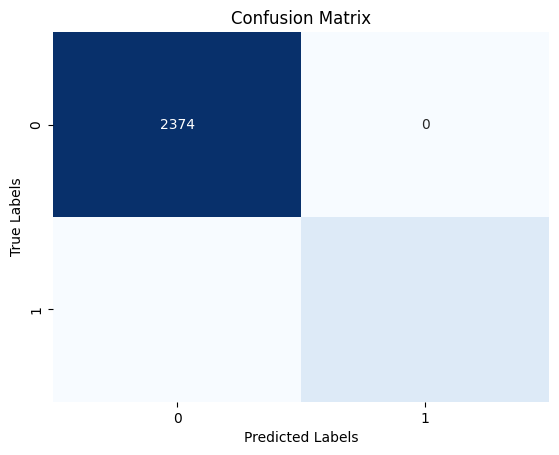

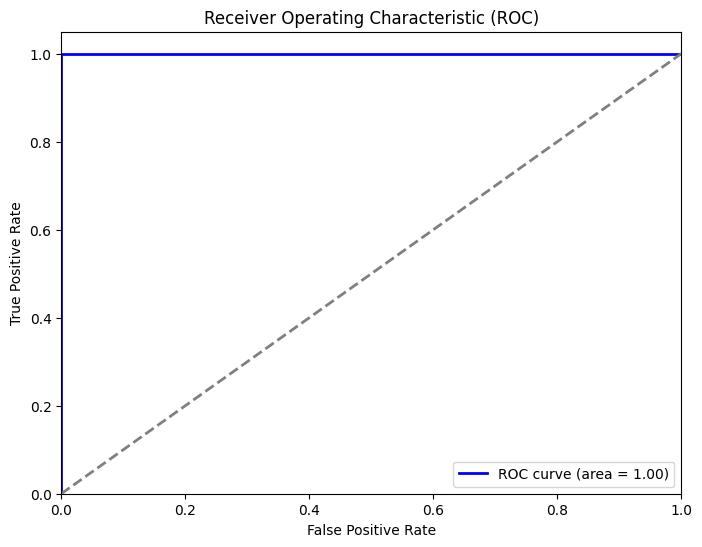

In [32]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [33]:
#df_complete_l33.shape
#df_complete.columns
df_complete_l33['machine'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

# LINEAR REGRESSION

In [34]:
# Entrenar el modelo de Regresión Lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predicciones con el modelo de Regresión Lineal
y_pred_linear = linear_model.predict(X_test)

# Dado que se trata de una clasificación, podemos redondear las predicciones para obtener 0 o 1
y_pred_linear_rounded = np.round(y_pred_linear)

# Evaluar el modelo de Regresión Lineal
print("Regresión Lineal - Classification Report")
print(classification_report(y_test, y_pred_linear_rounded))
print(f'AUC-ROC: {roc_auc_score(y_test, y_pred_linear)}')

# Calcular MAE y MSE para el modelo de Regresión Lineal
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)

print(f'Mean Absolute Error (MAE) - Linear Regression: {mae_linear}')
print(f'Mean Squared Error (MSE) - Linear Regression: {mse_linear}')

Regresión Lineal - Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2374
           1       0.71      0.63      0.67       309

    accuracy                           0.93      2683
   macro avg       0.83      0.80      0.81      2683
weighted avg       0.92      0.93      0.93      2683

AUC-ROC: 0.9814808756131009
Mean Absolute Error (MAE) - Linear Regression: 0.08018933547308713
Mean Squared Error (MSE) - Linear Regression: 0.03809937622744763


# DECISION TREE

Árbol de Decisión - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2374
           1       1.00      1.00      1.00       309

    accuracy                           1.00      2683
   macro avg       1.00      1.00      1.00      2683
weighted avg       1.00      1.00      1.00      2683

AUC-ROC: 0.9983818770226538
Mean Absolute Error (MAE) - Decision Tree: 0.0003727171077152441
Mean Squared Error (MSE) - Decision Tree: 0.0003727171077152441


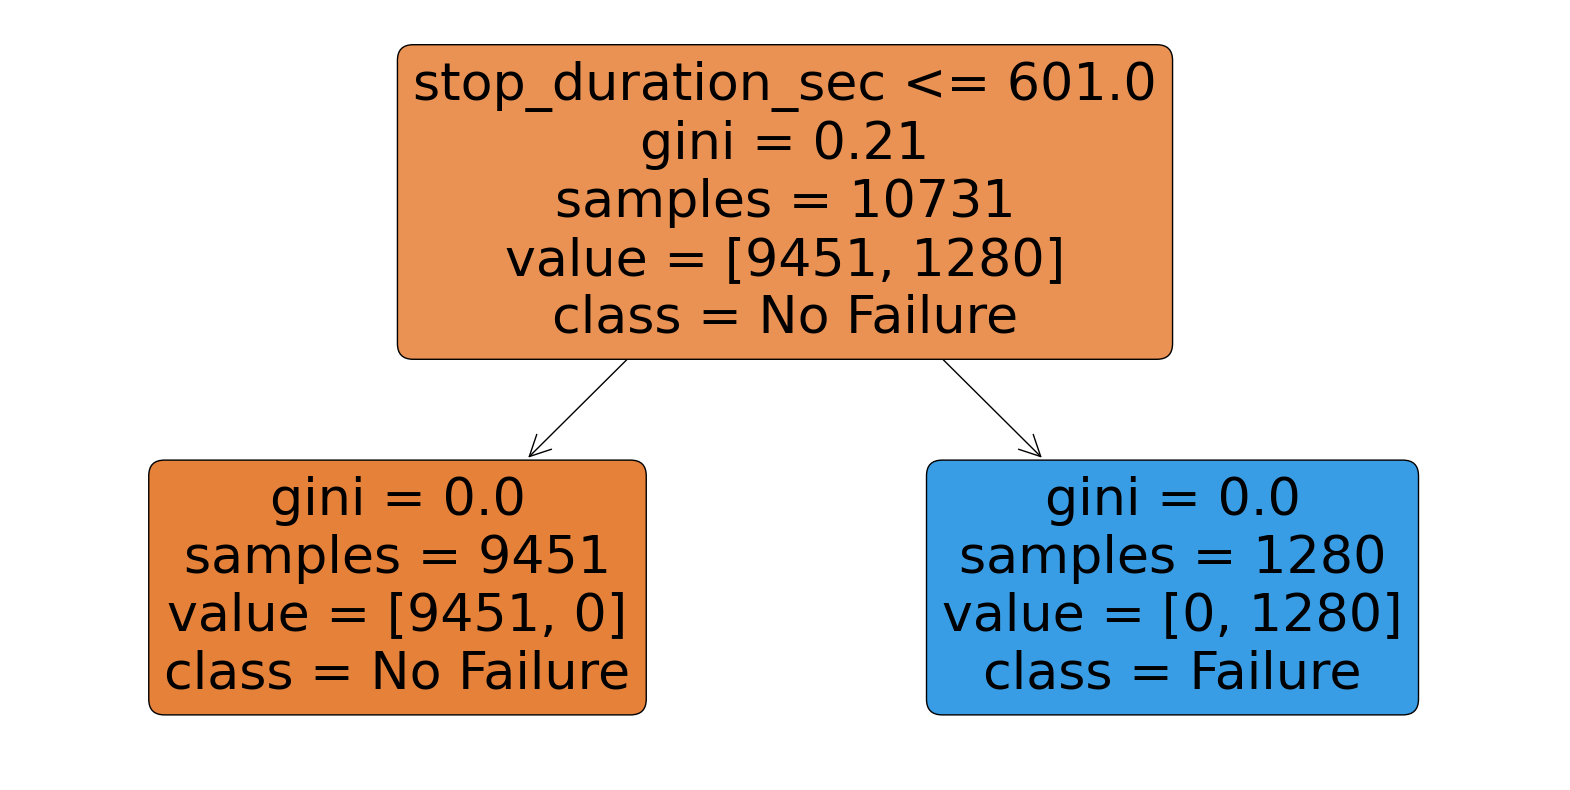

In [35]:
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Predicciones con el modelo de Árbol de Decisión
y_pred_tree = decision_tree_model.predict(X_test)
y_prob_tree = decision_tree_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo de Árbol de Decisión
print("Árbol de Decisión - Classification Report")
print(classification_report(y_test, y_pred_tree))
print(f'AUC-ROC: {roc_auc_score(y_test, y_prob_tree)}')

# Calcular MAE y MSE para el modelo de Árbol de Decisión
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)

print(f'Mean Absolute Error (MAE) - Decision Tree: {mae_tree}')
print(f'Mean Squared Error (MSE) - Decision Tree: {mse_tree}')

# Visualizar el árbol de decisión (opcional)
plt.figure(figsize=(20,10))
tree.plot_tree(decision_tree_model, 
               filled=True, 
               feature_names=X.columns.tolist(),  # Convertir Index a lista
               class_names=['No Failure', 'Failure'], 
               rounded=True)
plt.show()

# Support Vector Machine

In [36]:
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predicciones con el modelo de SVM
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo de SVM
print("Support Vector Machine (SVM) - Classification Report")
print(classification_report(y_test, y_pred_svm))
print(f'AUC-ROC: {roc_auc_score(y_test, y_prob_svm)}')

# Calcular MAE y MSE para el modelo de SVM
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)

print(f'Mean Absolute Error (MAE) - SVM: {mae_svm}')
print(f'Mean Squared Error (MSE) - SVM: {mse_svm}')

Support Vector Machine (SVM) - Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2374
           1       0.93      0.94      0.93       309

    accuracy                           0.98      2683
   macro avg       0.96      0.97      0.96      2683
weighted avg       0.98      0.98      0.98      2683

AUC-ROC: 0.9990362148736446
Mean Absolute Error (MAE) - SVM: 0.01528140141632501
Mean Squared Error (MSE) - SVM: 0.01528140141632501


# NEURONAL NETWORK

In [37]:
model_nn = Sequential()
model_nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Capa de entrada con 64 neuronas y activación ReLU
model_nn.add(Dense(32, activation='relu'))  # Capa oculta con 32 neuronas y activación ReLU
model_nn.add(Dense(1, activation='sigmoid'))  # Capa de salida con 1 neurona y activación sigmoide para clasificación binaria

# Compilar la Red Neuronal
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar la Red Neuronal
history = model_nn.fit(X_train, y_train, epochs=100, batch_size=100, validation_split=0.2, verbose=1)

# Predicciones con la Red Neuronal
y_pred_nn_prob = model_nn.predict(X_test)
y_pred_nn = np.round(y_pred_nn_prob)

# Evaluar el Modelo
print("Red Neuronal - Classification Report")
print(classification_report(y_test, y_pred_nn))
print(f'AUC-ROC: {roc_auc_score(y_test, y_pred_nn_prob)}')

# Calcular MAE y MSE para la Red Neuronal
mae_nn = mean_absolute_error(y_test, y_pred_nn_prob)
mse_nn = mean_squared_error(y_test, y_pred_nn_prob)

print(f'Mean Absolute Error (MAE) - Neural Network: {mae_nn}')
print(f'Mean Squared Error (MSE) - Neural Network: {mse_nn}')

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9638 - loss: 64.1032 - val_accuracy: 0.9772 - val_loss: 1.9438
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 4.2397 - val_accuracy: 0.9735 - val_loss: 2.3793
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9760 - loss: 3.4662 - val_accuracy: 0.9865 - val_loss: 0.1401
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 4.1718 - val_accuracy: 0.9660 - val_loss: 2.1687
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9722 - loss: 6.1798 - val_accuracy: 0.9856 - val_loss: 0.1506
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 3.3002 - val_accuracy: 0.9739 - val_loss: 13.8335
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9730 - loss: 12.6420 - val_accuracy: 0.9823 - val_loss: 7.8171
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9741 - loss: 13.5852 - val_accuracy: 0.9772

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.9037 - val_accuracy: 0.9921 - val_loss: 0.1000
Epoch 52/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.4614 - val_accuracy: 0.9874 - val_loss: 0.2368
Epoch 53/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.3183 - val_accuracy: 0.9930 - val_loss: 0.0230
Epoch 54/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.3832 - val_accuracy: 0.9912 - val_loss: 0.1601
Epoch 55/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 1.5772 - val_accuracy: 0.9804 - val_loss: 4.2455
Epoch 56/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9836 - loss: 1.9892 - val_accuracy: 0.9893 - val_loss: 0.1656
Epoch 57/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9893 - loss: 0.8099 - val_accuracy: 0.9921 - val_loss: 0.3772
Epoch 58/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9937 - loss: 0.2465 - val_accuracy: 0.9939 - val_lo

In [42]:
df_complete_l33.sort_values(by=['machine', 'stop_date'], inplace=True)  # Sort the DataFrame by 'Machine' and 'Stop_date'
df_complete_l33['uptime'] = df_complete_l33.groupby('machine')['stop_date'].diff().dt.total_seconds() / 60  # Convert to minutes
df_complete_l33['uptime'].fillna(0, inplace=True)
print(df_complete_l33[['machine', 'stop_date', 'uptime']].head(10))

      machine  stop_date  uptime
8877        0 2022-01-12       0
8889        0 2022-01-24   17280
8891        0 2022-01-26    2880
8981        0 2022-04-26  129600
9040        0 2022-06-24   84960
9050        0 2022-07-04   14400
9141        0 2022-10-03  131040
9142        0 2022-10-03       0
9145        0 2022-10-06    4320
9146        0 2022-10-06       0


In [43]:
X_train_new = df_complete_l33[['machine', 'uptime']]
y_train_new = df_complete_l33['failure']  # Tu variable objetivo

# Entrenar un nuevo modelo
model_new = RandomForestClassifier(n_estimators=1000, random_state=42)
model_new.fit(X_train_new, y_train_new)

X_pre = df_complete_l33[['machine', 'uptime']]
# Usar este nuevo modelo para predecir
y_pred_prob = model_new.predict_proba(X_pre)[:, 1]  # Obtener la probabilidad de la clase 1 (falla)
y_pred_class = (y_pred_prob >= 0.5).astype(int)  # Clasificar en 0 o 1 basado en la probabilidad

# Agregar las predicciones al DataFrame original
df_complete_l33['predicted_failure'] = y_pred_class
df_complete_l33['predicted_failure_probability'] = y_pred_prob

In [44]:
print(df_complete_l33[['machine', 'stop_date', 'Uptime', 'predicted_failure', 'predicted_failure_probability']])

      machine  stop_date  Uptime  predicted_failure  predicted_failure_probability
8877        0 2022-01-12       0                  0                      0.0125552
8889        0 2022-01-24   17280                  1                        0.96775
8891        0 2022-01-26    2880                  1                       0.921535
8981        0 2022-04-26  129600                  1                          0.967
9040        0 2022-06-24   84960                  0                          0.341
...       ...        ...     ...                ...                            ...
878        13        NaT       0                  0                              0
879        13        NaT       0                  0                              0
880        13        NaT       0                  0                              0
881        13        NaT       0                  0                              0
882        13        NaT       0                  0                              0

[13

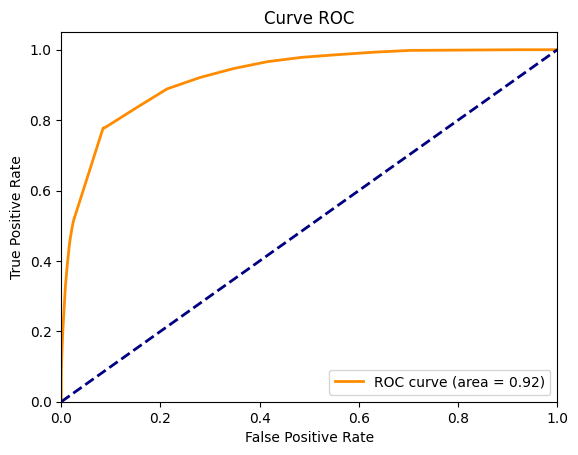

In [58]:
fpr, tpr, _ = roc_curve(df_complete_l33['failure'], df_complete_l33['predicted_failure_probability'])
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curve ROC')
plt.legend(loc='lower right')
plt.show()

      machine  stop_date  Uptime  predicted_failure_adjusted  failure
8877        0 2022-01-12       0                           0        0
8889        0 2022-01-24   17280                           1        1
8891        0 2022-01-26    2880                           1        1
8981        0 2022-04-26  129600                           1        1
9040        0 2022-06-24   84960                           0        0
...       ...        ...     ...                         ...      ...
878        13        NaT       0                           0        0
879        13        NaT       0                           0        0
880        13        NaT       0                           0        0
881        13        NaT       0                           0        0
882        13        NaT       0                           0        0

[13414 rows x 5 columns]


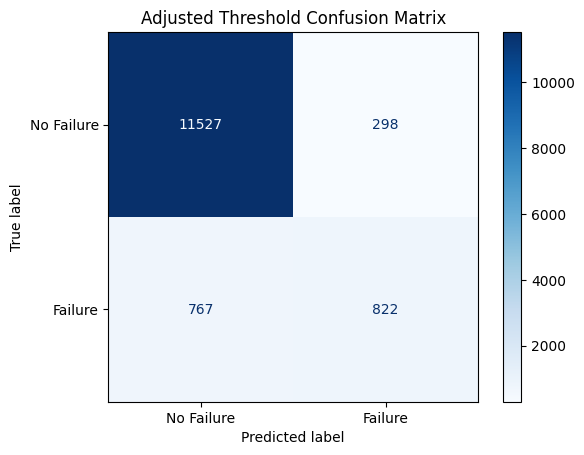

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ajustar el umbral de clasificación
y_pred_class_adjusted = (y_pred_prob >= 0.4).astype(int)

# Agregar las predicciones ajustadas al DataFrame
df_complete_l33['predicted_failure_adjusted'] = y_pred_class_adjusted

# Comparar las predicciones ajustadas con las reales
print(df_complete_l33[['machine', 'stop_date', 'Uptime', 'predicted_failure_adjusted', 'failure']])

# Podrías también graficar la matriz de confusión para este nuevo umbral
cm_adjusted = confusion_matrix(df_complete_l33['failure'], df_complete_l33['predicted_failure_adjusted'])
disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=['No Failure', 'Failure'])
disp_adjusted.plot(cmap=plt.cm.Blues)
plt.title("Adjusted Threshold Confusion Matrix")
plt.show()

In [52]:
df_complete_l33.shape

(13414, 19)

In [59]:
machine_encoder = LabelEncoder()
line_encoder = LabelEncoder()
stop_cause_description_encoder = LabelEncoder()
detail_encoder = LabelEncoder()

# Encajamos los LabelEncoders con los valores originales antes de la codificación
machine_encoder.fit(original_machine_values)
line_encoder.fit(original_line_values)
stop_cause_description_encoder.fit(original_stop_cause_description_values)
detail_encoder.fit(original_detail_values)

# Decodificar las columnas
df_complete_l33['machine_decoded'] = machine_encoder.inverse_transform(df_complete_l33['machine'])
df_complete_l33['line_decoded'] = line_encoder.inverse_transform(df_complete_l33['line'])
df_complete_l33['stop_cause_description_decoded'] = stop_cause_description_encoder.inverse_transform(df_complete_l33['stop_cause_description'])
df_complete_l33['detail_decoded'] = detail_encoder.inverse_transform(df_complete_l33['detail'])

print(df_complete_l33[['machine', 'machine_decoded', 'line', 'line_decoded']])

NameError: name 'original_machine_values' is not defined